In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.transforms as T
from torchvision import datasets
from torchvision.utils import make_grid

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from torchsummary import summary

In [2]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(42)

In [3]:
mean = [0.4914, 0.4821, 0.4465]
std = [0.2470, 0.2435, 0.2616]

In [4]:
def apply_transforms():
    train_transforms = A.Compose([
        A.HorizontalFlip(p=0.2),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=0.2),
        A.CoarseDropout(
            max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16, fill_value=tuple((x * 255.0 for x in mean)), p=0.2,
        ),
        A.ToGray(p=0.15),
        A.Normalize(mean=mean, std=std, always_apply=True),
        ToTensorV2(),
    ])

    test_transforms = A.Compose([
        A.Normalize(mean=mean, std=std, always_apply=True),
        ToTensorV2(),
    ])

    return lambda img: train_transforms(image=np.array(img))["image"], lambda img: test_transforms(image=np.array(img))["image"]


train_transforms, test_transforms = apply_transforms()

In [5]:
train_dataset = datasets.CIFAR10(root='data/', train=True, download=True, transform=train_transforms)
test_dataset = datasets.CIFAR10(root='data/', train=False, download=False, transform=test_transforms)

Files already downloaded and verified


In [6]:
labels = train_dataset.classes
labels

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [7]:
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True, pin_memory=True, num_workers=2)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False, pin_memory=True, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

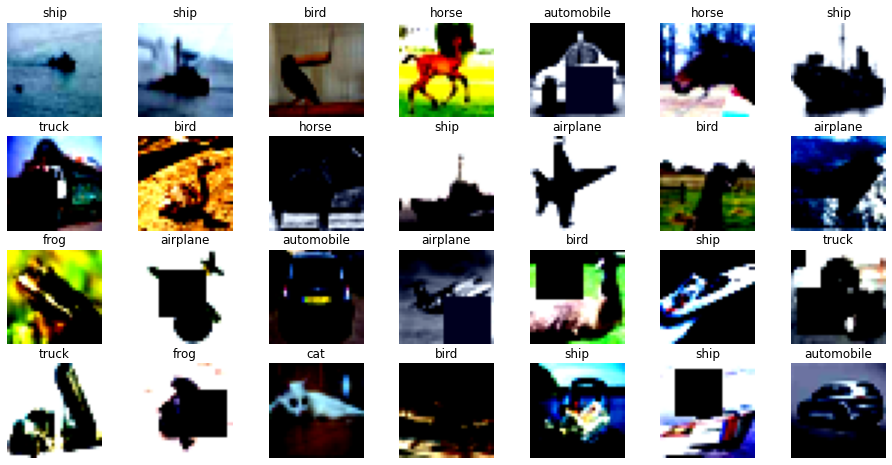

In [8]:
def show_batch(data_loader):
    images, targets = next(iter(data_loader))
    plt.figure(figsize=(16, 8))
    for i in range(28):
        ax = plt.subplot(4, 7, i + 1)
        ax.imshow(images[i].permute(1, 2, 0))
        plt.title(labels[targets[i]])
        plt.axis('off')

show_batch(train_loader)

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device

device(type='cuda')

In [10]:
class CIFAR10Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, bias=False), # RF: 3x3
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.05),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, bias=False), # RF: 5x5
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.05),
        )

        self.trans1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.05),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.05),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, groups=32, bias=False),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.05),
        )

        self.trans2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.05),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, dilation=2, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(0.05),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(0.05),
        )

        self.trans3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(0.05),
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(0.05),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, groups=64, bias=False),
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=1, padding=1, bias=False),
            # nn.ReLU(),
            # nn.BatchNorm2d(10),
            # nn.Dropout2d(0.05),
        )

        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(x)

        x = self.conv2(x) 
        x = self.trans2(x) 

        x = self.conv3(x) 
        x = self.trans3(x)

        x = self.conv4(x)
        x = self.gap(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=1)

In [11]:
model = CIFAR10Model().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
         Dropout2d-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
         Dropout2d-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 15, 15]           9,248
             ReLU-10           [-1, 32, 15, 15]               0
      BatchNorm2d-11           [-1, 32, 15, 15]              64
        Dropout2d-12           [-1, 32, 15, 15]               0
           Conv2d-13           [-1, 32, 15, 15]           9,216
             ReLU-14           [-1, 32,

In [12]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [13]:
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []
lrs = []

epochs = 100
l1_factor = 0
l2_factor = 0.0001
lr = 0.01
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = F.nll_loss
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=epochs, steps_per_epoch=len(train_loader))


def train(model, device, train_loader, optimizer, epoch, train_acc, train_loss, lambda_l1, scheduler, criterion, lrs, grad_clip=None):
    model.train()
    pbar = tqdm(train_loader)
  
    correct = 0
    processed = 0
  
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        y_pred = model(data)


        loss = criterion(y_pred, target)

        #L1 Regularization
        if lambda_l1 > 0:
            l1 = 0
            for p in model.parameters():
                l1 = l1 + p.abs().sum()
                loss = loss + lambda_l1 * l1

        train_loss.append(loss.data.cpu().numpy().item())

        # Backpropagation
        loss.backward()

        # Gradient clipping
        if grad_clip: 
            nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
        optimizer.step()
        # scheduler.step()
        lrs.append(get_lr(optimizer))

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Train Loss={loss.item()} Batch_id={batch_idx} LR={lrs[-1]: 0.5f} Train Accuracy={100 * correct / processed: 0.2f}')
        train_acc.append(100 * correct / processed)

In [14]:
def test(model, device, test_loader, test_acc, test_losses, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\n: Average Test loss: {:.4f}, Test Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [15]:
for epoch in range(1, epochs + 1):
    print(f'Epoch {epoch}:')
    train(model, device, train_loader, optimizer, epochs, train_accuracy, train_losses, l1_factor, scheduler, criterion, lrs)
    test(model, device, test_loader, test_accuracy, test_losses, criterion)

  0%|          | 0/391 [00:00<?, ?it/s]Epoch 1:
Train Loss=1.5754234790802002 Batch_id=390 LR= 0.00040 Train Accuracy= 33.25: 100%|██████████| 391/391 [00:09<00:00, 42.64it/s]
  0%|          | 0/391 [00:00<?, ?it/s]
: Average Test loss: 0.0111, Test Accuracy: 4868/10000 (48.68%)

Epoch 2:
Train Loss=1.2287570238113403 Batch_id=390 LR= 0.00040 Train Accuracy= 49.62: 100%|██████████| 391/391 [00:09<00:00, 42.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]
: Average Test loss: 0.0088, Test Accuracy: 6025/10000 (60.25%)

Epoch 3:
Train Loss=1.27358078956604 Batch_id=390 LR= 0.00040 Train Accuracy= 56.36: 100%|██████████| 391/391 [00:09<00:00, 41.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]
: Average Test loss: 0.0077, Test Accuracy: 6481/10000 (64.81%)

Epoch 4:
Train Loss=0.9607405662536621 Batch_id=390 LR= 0.00040 Train Accuracy= 60.61: 100%|██████████| 391/391 [00:09<00:00, 41.31it/s]
  0%|          | 0/391 [00:00<?, ?it/s]
: Average Test loss: 0.0068, Test Accuracy: 6983/10000 (69.8

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

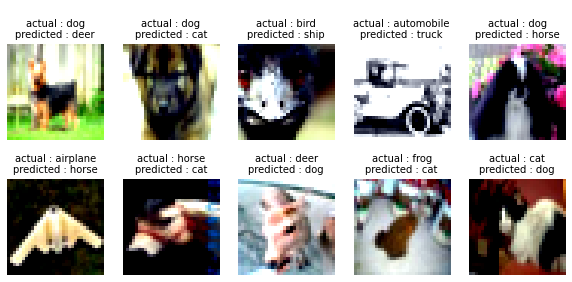

In [17]:
def misclassified_images(model):
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
            
    wrong_images=[]
    wrong_label=[]
    correct_label=[]
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)        
            pred = output.argmax(dim=1, keepdim=True).squeeze()  # get the index of the max log-probability

            wrong_pred = (pred.eq(target.view_as(pred)) == False)
            wrong_images.append(data[wrong_pred])
            wrong_label.append(pred[wrong_pred])
            correct_label.append(target.view_as(pred)[wrong_pred])  

            wrong_predictions = list(zip(torch.cat(wrong_images),torch.cat(wrong_label),torch.cat(correct_label)))    
        print(f'Total wrong predictions are {len(wrong_predictions)}')


        fig = plt.figure(figsize=(10,12))
        fig.tight_layout()

        for i, (img, pred, correct) in enumerate(wrong_predictions[:10]):
                img, pred, target = img.cpu().numpy(), pred.cpu(), correct.cpu()
                
                img = np.transpose(img, (1, 2, 0)) / 2 + 0.5
                ax = fig.add_subplot(5, 5, i+1)
                ax.axis('off')
                ax.set_title(f'\nactual : {class_names[target.item()]}\npredicted : {class_names[pred.item()]}',fontsize=10)  
                ax.imshow(img)  
        
        plt.show()

misclassified_images(model)

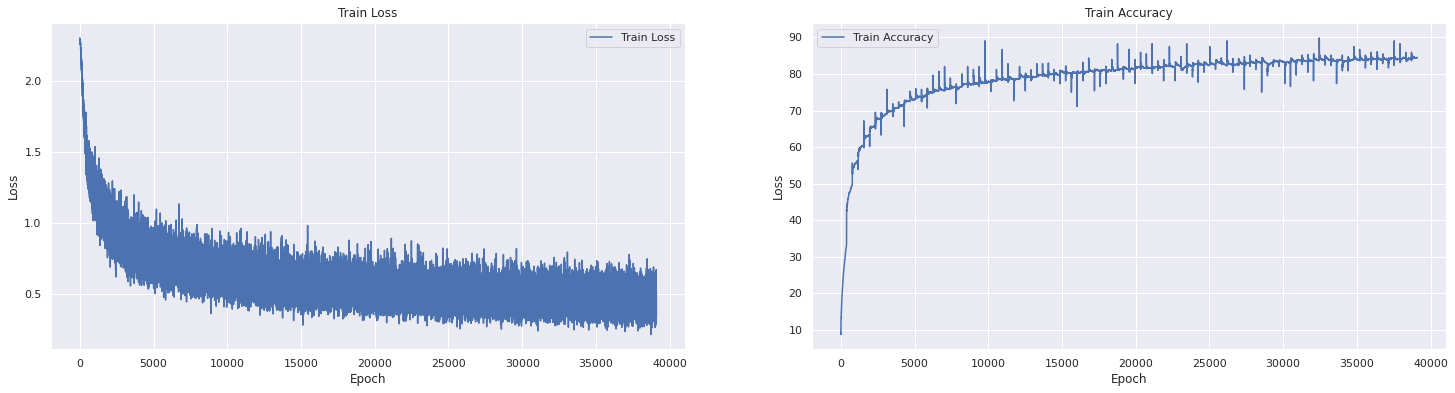

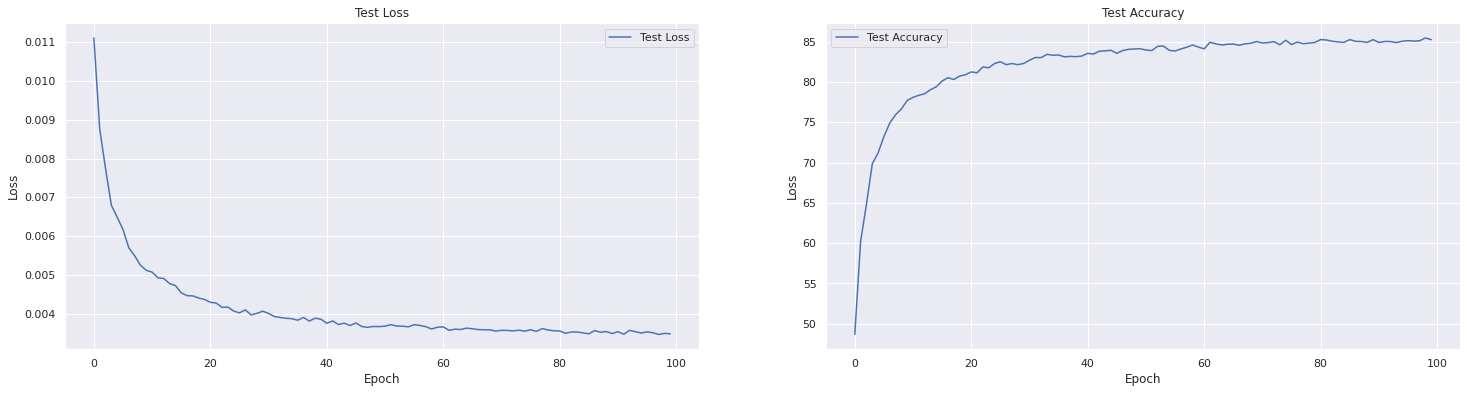

In [21]:
import seaborn as sns

def plot_metrics(exp_metrics):
    sns.set(font_scale=1)
    plt.rcParams["figure.figsize"] = (25,6)
    train_accuracy, train_losses, test_accuracy, test_losses  = exp_metrics

    # Plot the learning curve.
    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.plot(np.array(train_losses), 'b', label="Train Loss")
    
    # Label the plot.
    ax1.set_title("Train Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    
    ax2.plot(np.array(train_accuracy), 'b', label="Train Accuracy")
    
    # Label the plot.
    ax2.set_title("Train Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend()
    
    plt.show()
    
    # Plot the learning curve.
    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.plot(np.array(test_losses), 'b', label="Test Loss")
    
    # Label the plot.
    ax1.set_title("Test Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    
    ax2.plot(np.array(test_accuracy), 'b', label="Test Accuracy")
    
    # Label the plot.
    ax2.set_title("Test Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend()
    
    plt.show()

plot_metrics((train_accuracy, train_losses, test_accuracy, test_losses))

In [20]:
def class_level_accuracy(model, loader, device, classes):

    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))

    with torch.no_grad():
        for _, (images, labels) in enumerate(loader, 0):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()

            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

class_level_accuracy(model, test_loader, device, labels)

Accuracy of airplane : 88 %
Accuracy of automobile : 93 %
Accuracy of  bird : 76 %
Accuracy of   cat : 68 %
Accuracy of  deer : 84 %
Accuracy of   dog : 76 %
Accuracy of  frog : 91 %
Accuracy of horse : 89 %
Accuracy of  ship : 91 %
Accuracy of truck : 91 %


In [25]:
torch.save(model,'model_1.pt')

/home/shreeyash-legion/miniconda3/envs/graphdrp/lib/python3.8/site-packages/torch/serialization.py:359: UserWarning: Couldn't retrieve source code for container of type CIFAR10Model. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "
